In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

### 데이터 구조

- datetime: 날짜 + 시간
- season: 계절 (1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울)
- holiday: 휴일여부(주말 포함 x)
- workingday: 근무여부 (주말과 휴일을 제외한 일하는 날 여부)
- weather: 날씨
  - 1: 맑음, 구름 조금, 부분 흐림
  - 2: 안개 + 흐림, 안개 + 구름, 안개 + 구름 조금, 안개
  - 3: 가벼운 눈, 가벼운 비 + 천둥 + 구름, 가벼운 비 + 구름
  - 4: 폭우 + 우박 + 천둥 + 안개, 눈 + 안개
- temp: 온도
- atemp: 체감온도
- humidity: 습도
- windspeed: 풍속
- casual: 미등록 사용자 대여량
- registered: 등록 사용자 대여량
- count: 총 대여량

In [3]:
bike_df = pd.read_csv('./bike_train.csv')
bike_df.head(3)

# 날짜 변수 반영 ↓
# bike_df = pd.read_csv('train.csv', parse_dates = ["datetime"])

,daylabel,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,1,2011,1,1,0,1,0,0,1.0,9.84,14.395,81.0,0.0,16
1,1,2011,1,1,1,1,0,0,1.0,9.02,13.635,80.0,0.0,40
2,1,2011,1,1,2,1,0,0,1.0,9.02,13.635,80.0,0.0,32


In [4]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10932 entries, 0 to 10931
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   daylabel    10932 non-null  int64  
 1   year        10932 non-null  int64  
 2   month       10932 non-null  int64  
 3   day         10932 non-null  int64  
 4   hour        10932 non-null  int64  
 5   season      10932 non-null  int64  
 6   holiday     10932 non-null  int64  
 7   workingday  10932 non-null  int64  
 8   weather     10932 non-null  float64
 9   temp        10932 non-null  float64
 10  atemp       10932 non-null  float64
 11  humidity    10932 non-null  float64
 12  windspeed   10932 non-null  float64
 13  count       10932 non-null  int64  
dtypes: float64(5), int64(9)
memory usage: 1.2 MB


## 성능평가함수

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# MAE, RMSE, RMSLE 반환
def evaluate_regr(y,pred):
    # MAE
    mae = mean_absolute_error(y,pred)
    
    # RMSE
    rmse = np.sqrt(mean_squared_error(y,pred))
    
    # RMSLE
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    msle = np.mean((log_y - log_pred) ** 2)
    rmsle = np.sqrt(msle)    
    
    print(f'MAE: {mae:.3f}, RMSE: {rmse:.3f}, RMSLE: {rmsle:.3f}')

### 선형회귀

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_features = bike_df.drop(['count'],axis=1,inplace=False)
y_target = bike_df['count']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

# LinearRegression
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

MAE: 105.846, RMSE: 139.215, RMSLE: 1.205


In [9]:
def get_top_error_data(y_test, pred, n_tops = 5):
    # 예측값, 실제값 데이터 프레임
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    
    # 예측값과 실제값의 차이가 큰 순서로 출력
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(y_test,pred,n_tops=10)

      real_count  predicted_count   diff
637          835            218.0  617.0
2073         809            203.0  606.0
2510         731            149.0  582.0
2535         917            347.0  570.0
415          785            245.0  540.0
121          856            321.0  535.0
2912         684            149.0  535.0
1483         724            206.0  518.0
27           666            148.0  518.0
2995         759            249.0  510.0


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


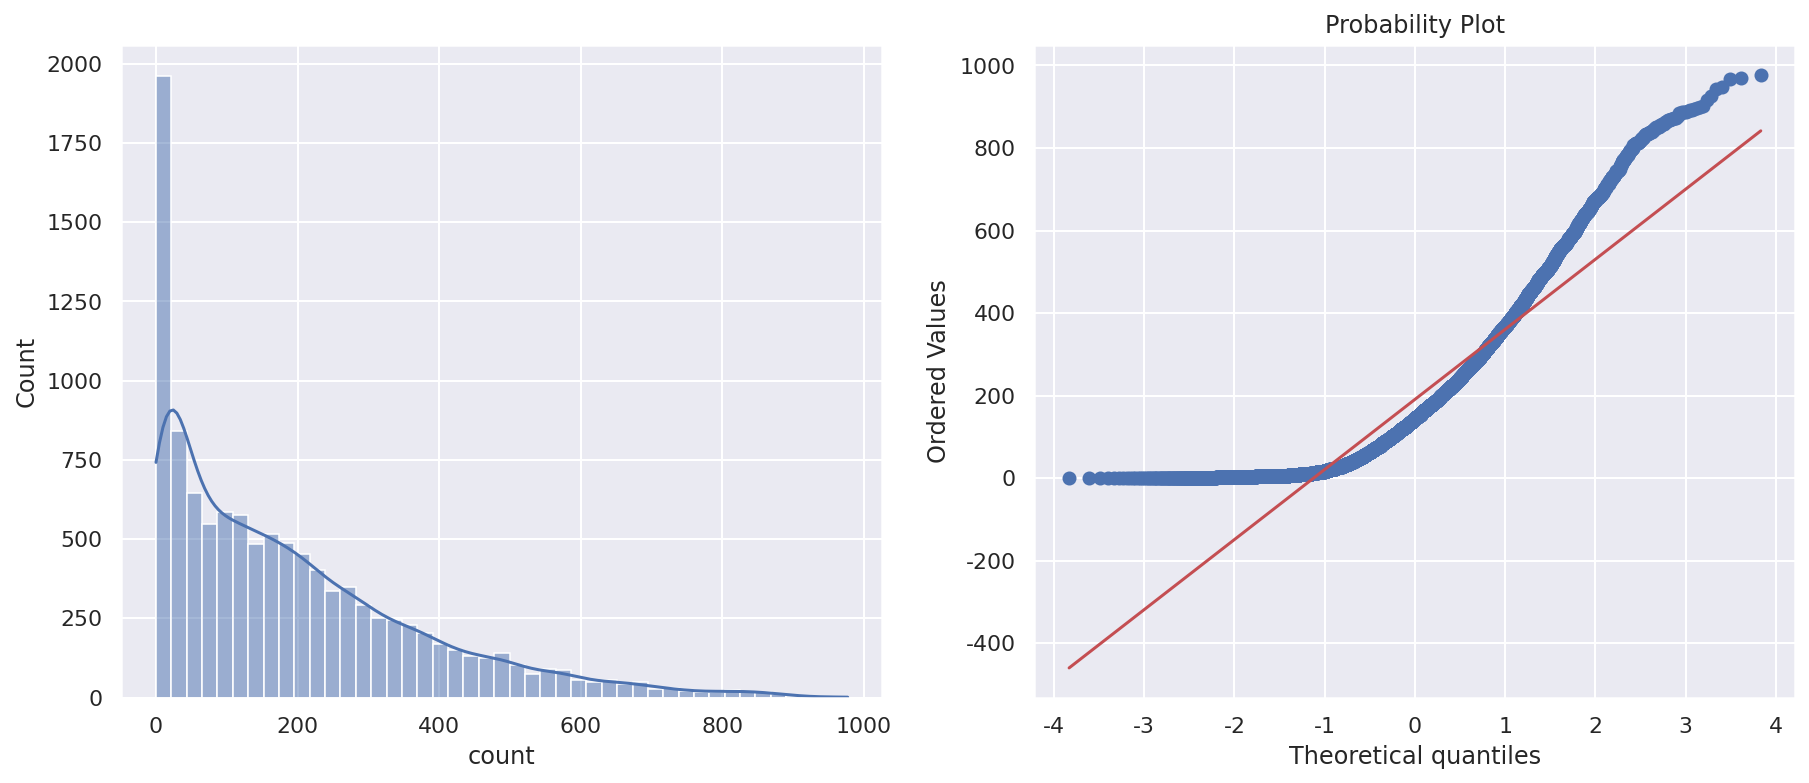

In [10]:
from scipy import stats

fig, axs = plt.subplots(1,2, figsize = (15,6))

sns.histplot(bike_df["count"], ax =axs[0], kde=True)
stats.probplot(bike_df["count"], dist='norm', fit=True, plot=axs[1])

plt.show()

#### 종속 변수가 정규분포 형태를 따르지 않으면 회귀 예측 성능이 저하될 가능성이 높은데 종속변수의 분포는 왼쪽으로 치우쳐져 있다.
#### 따라서 종속 변수를 정규분포 형태로 바꾸는 방법으로 로그 변환을 적용 해본다.

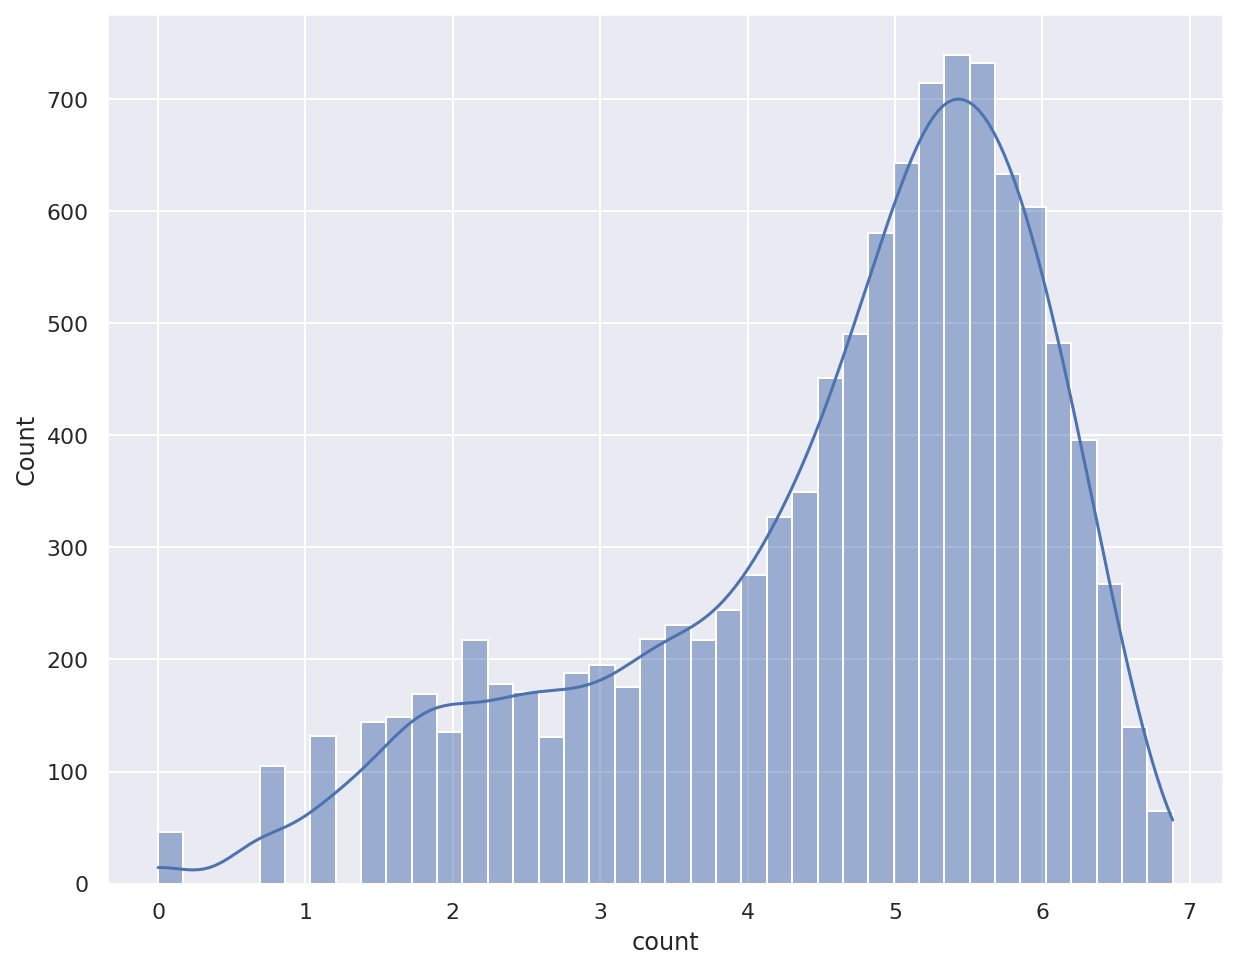

In [11]:
sns.histplot(np.log1p(bike_df["count"]), kde=True)
plt.show()

로그 변환 후 분포 역시 정규분포를 따른다고 보기 힘들지만 변환 전보다는 왜곡 정도가 완화되어 이대로 학습을 진행한다.

In [12]:
# target 로그 변환
y_target_log = np.log1p(y_target)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

# 로그 변환 후 학습/예측
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 예측값, 실제값 원래 스케일로 변환
y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)

MAE: 106.591, RMSE: 160.666, RMSLE: 1.039


RMSLE는 줄었지만 MAE, RMSE는 증가하였다.

In [13]:
# 카테고리 피처 원-핫 인코딩
X_features_ohe = pd.get_dummies(X_features, columns=['year','month','hour', 'holiday','workingday','season','weather'])

X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

In [14]:
from sklearn.linear_model import Ridge, Lasso

def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)

In [15]:
# LinearRegression, Ridge, Lasso
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

# 성능 평가
models = [lr_reg, ridge_reg, lasso_reg]

for model in models:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
MAE: 59.485, RMSE: 92.149, RMSLE: 0.593
### Ridge ###
MAE: 60.202, RMSE: 93.433, RMSLE: 0.598
### Lasso ###
MAE: 68.547, RMSE: 106.394, RMSLE: 0.643


종속 변수의 로그 변환, 카테고리 피처 원-핫 인코딩 이후 선형 회귀 모델의 예측 성능이 많이 향상되었다.